In [33]:
import re
import pandas as pd
import nltk
# nltk.download('punkt') ----> udkommenter denne linje, hvis du ikke har nltk installeret
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
# nltk.download('stopwords')
from nltk.stem import PorterStemmer

# to clean data faster we'll use the multiprocessing library
from multiprocessing import Pool

# to clean data even faster we'll use the dask library to parallelize the cleaning process
import dask.dataframe as dd

import sklearn as sk

In [34]:
data = pd.read_csv('995,000_rows.csv',dtype = str)

# print(data.head())

def cleanText(text):
    # lower case
    if not isinstance(text, str):
        return text
    text = text.lower()

    # should not contain multiple spaces, tabs or newlines
    text = re.sub(r'\s+', ' ', text)

    # date and time stuff
    # text = re.sub(r'\b(?:the )?(\d{1,2})(?:st|nd|rd|th)?\s*(?:of\s+)?(January|February|March|April|May|June|July|August|September|October|November|December)\b', '<DATE>', text)
    # text = re.sub(r'r"([a-zA-Z]{3}\s\d{1,2}\s\d{4})"', '<DATE>', text, flags=re.IGNORECASE)
    # text = re.sub(r'\b(?:the )?(\d{1,2})(?:st|nd|rd|th)?(?: of)?(?: (?:jan(?:uary)?|feb(?:ruary)?|mar(?:ch)?|apr(?:il)?|may|jun(?:e)?|jul(?:y)?|aug(?:ust)?|sep(?:tember)?|oct(?:ober)?|nov(?:ember)?|dec(?:ember)?))(?: (\d{4}|\d{2}))?\b', '<DATE>', text)
    # text = re.sub(r'\b(?:the )?(\d{1,2})(?:st|nd|rd|th)?(?: of)?(?: (?:jan(?:uary)?|feb(?:ruary)?|mar(?:ch)?|apr(?:il)?|may|jun(?:e)?|jul(?:y)?|aug(?:ust)?|sep(?:tember)?|oct(?:ober)?|nov(?:ember)?|dec(?:ember)?|Jan(?:uary)?|Feb(?:ruary)?|Mar(?:ch)?|Apr(?:il)?|May|Jun(?:e)?|Jul(?:y)?|Aug(?:ust)?|Sep(?:tember)?|Oct(?:ober)?|Nov(?:ember)?|Dec(?:ember)?))(?: (\d{4}|\d{2}))?\b', '<DATE>', text)

    # replace dates with <DATE>
    #  january 18, 2018. jan 18, 2018. 2018-01-18
    date_pattern = r'\b(?:jan(?:uary)?|feb(?:ruary)?|mar(?:ch)?|apr(?:il)?|may|jun(?:e)?|jul(?:y)?|aug(?:ust)?|sep(?:tember)?|oct(?:ober)?|nov(?:ember)?|dec(?:ember)?)\s+\d{1,2}(?:,\s+|\s+)\d{4}\b|\b\d{4}-\d{2}-\d{2}\b'

    # date_pattern = r'\b(?:jan(?:uary)?|feb(?:ruary)?|mar(?:ch)?|apr(?:il)?|may|jun(?:e)?|jul(?:y)?|aug(?:ust)?|sep(?:tember)?|oct(?:ober)?|nov(?:ember)?|dec(?:ember)?)\s+\d{1,2},\s+\d{4}\b|\b\d{4}-\d{2}-\d{2}\b'
    text = re.sub(date_pattern, '<DATE>', text)
    # nov. 5
    date_pattern2 = r'\b(?:jan(?:uary)?|feb(?:ruary)?|mar(?:ch)?|apr(?:il)?|may|jun(?:e)?|jul(?:y)?|aug(?:ust)?|sep(?:tember)?|oct(?:ober)?|nov(?:ember)?|dec(?:ember)?)\.\s+\d{1,2}\b'
    text = re.sub(date_pattern2, '<DATE>', text)

    # text = re.sub(r'\b(?:\d{1,2}[-/th|st|nd|rd\s]*)?(?:Jan(?:uary)?|Feb(?:ruary)?|Mar(?:ch)?|Apr(?:il)?|May|Jun(?:e)?|Jul(?:y)?|Aug(?:ust)?|Sep(?:tember)?|Oct(?:ober)?|Nov(?:ember)?|Dec(?:ember)?)(?:\s*(?:\d{1,2}[-/th|st|nd|rd\s]*))?(?:\s*(?:\d{4}|\d{2}))?\b', '<DATE>', text)


    # replace numbers with <NUM>
    text = re.sub(r'\d+', '<NUM>', text)

    # replace urls with <URL>
    text = re.sub(r'(http|https)://[^\s]*', '<URL>', text)

    # replace emails with <EMAIL>
    text = re.sub(r'\b[\w\.-]+@[\w\.-]+\.\w{2,4}\b', '<EMAIL>', text)


    # remove punctuation
    text = re.sub(r'[^\w\s]', '', text)

    return text

# data['content'] = data['content'].apply(cleanText)

# data.to_csv('cleaned_Bigdata.csv', index=False)



In [ ]:
# print(data.head())

# counting the number of URLs in the content
URL_count = data['content'].str.count(r'(http|https)://[^\s]*').sum()
print('URLs:', URL_count)

# counting the number of numeric values in the content
NUM_count = data['content'].str.count(r'\d+').sum()
print('NUMs:', NUM_count)



URLs: 215615.0
NUMs: 10621381.0


In [61]:
# print(data['type'])

# counting the number of each type of news
type_count = data['type'].value_counts()
print(type_count)

# see if there are any missing values in ['type']
missing_type = data['type'].isnull().sum()
print('Missing type:', missing_type)

# see if the sum of the missing values and the number of each type of news is equal to the total number of rows
total_rows = data.shape[0]
print('Total rows:', total_rows)

# counting the number of each type of news
type_count = data['type'].value_counts()
print(type_count)

# see how many different domains there are
domain_count = data['domain'].value_counts()
print("there are", len(domain_count), "different domains")




type
reliable                      218564
political                     194518
bias                          133232
fake                          104883
conspiracy                     97314
rumor                          56445
unknown                        43534
unreliable                     35332
clickbait                      27412
junksci                        14040
satire                         13160
hate                            8779
2018-02-10 13:43:39.521661         1
Name: count, dtype: int64
Missing type: 47786
Total rows: 995000
type
reliable                      218564
political                     194518
bias                          133232
fake                          104883
conspiracy                     97314
rumor                          56445
unknown                        43534
unreliable                     35332
clickbait                      27412
junksci                        14040
satire                         13160
hate                            8779


domain                             type                      
100percentfedup.com                bias                            10
2016-11-13T15:38:41.407+02:00      2018-02-10 13:43:39.521661       1
21stcenturywire.com                conspiracy                    2352
4threvolutionarywar.wordpress.com  bias                           631
70news.wordpress.com               fake                           261
                                                                 ... 
yournationnews.com                 clickbait                        4
yournewswire.com                   clickbait                     1230
zeenews.india.com                  reliable                       299
zerohedge.com                      conspiracy                    4185
zootfeed.com                       conspiracy                      22
Length: 619, dtype: int64


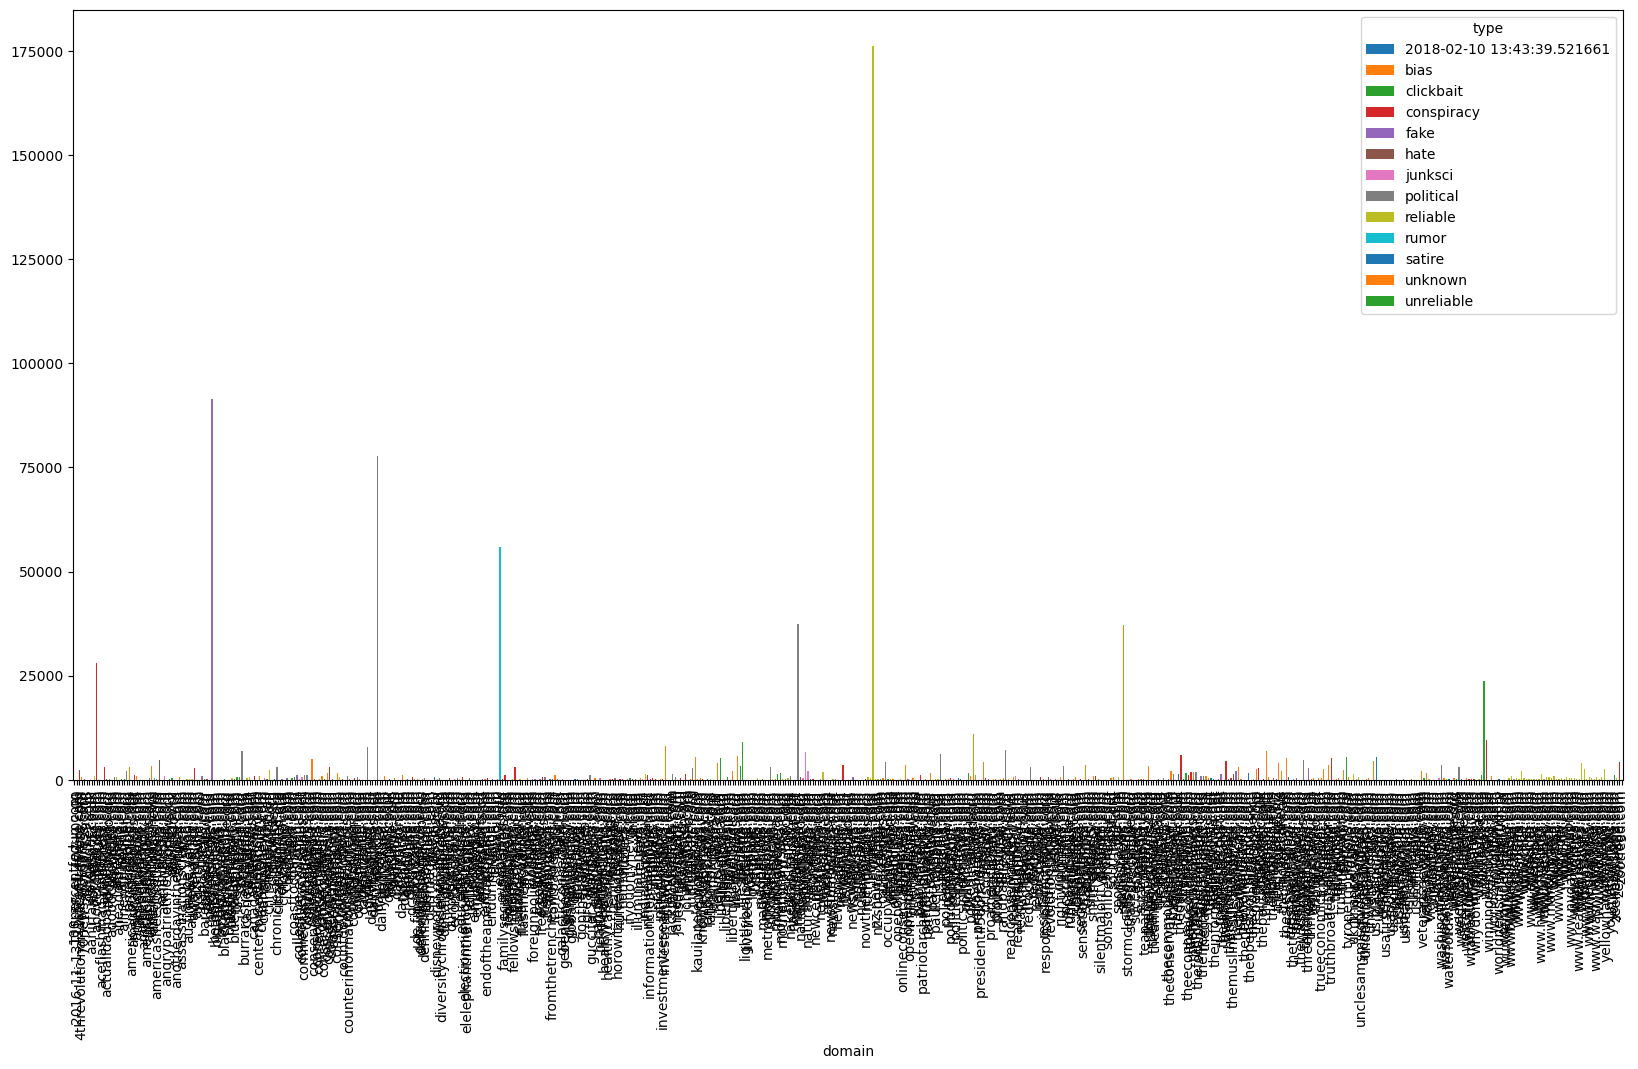

In [59]:
# see how many domains are in the dataset
domains = data['domain'].value_counts()
# print(domains)

# see if there are any missing values in ['domain']
missing_domain = data['domain'].isnull().sum()
# print('Missing domain:', missing_domain)

# see if how many domains have 'reliable' as their type
reliable_domains = data[data['type'] == 'reliable']['domain'].value_counts()
# print(reliable_domains)

# see for each domain how many reliable and fake news articles they have
reliable_fake = data.groupby(['domain', 'type']).size()
print(reliable_fake)

# plot the number of reliable and fake news articles for each domain
reliable_fake.unstack().plot(kind='bar', stacked=True, figsize=(20, 10))
plt.show()



In [36]:





# likely have to tokenize and stem the data like in the previous assignment, and then remove stopwords and count the vocabulary size
data['content'] = data['content'].apply(cleanText)




KeyboardInterrupt: 

In [31]:

# tokenize the text using nltk

# make the data content into a list
# data = data['content'].tolist()

print(data['content'].head())

tokens = data.apply(nltk.word_tokenize)

voocabulary_before = []
for token in tokens:
    for word in token:
        if word not in voocabulary_before:
            voocabulary_before.append(word)

print("vocabulary size before removing stop words: ", len(voocabulary_before))

# remove stop words

stop_words = set(stopwords.words('english'))

filtered_tokens = []

for token in tokens:
    filtered_words = []
    for word in token:
        if word not in stop_words:
            filtered_words.append(word)
    filtered_tokens.append(filtered_words)

# print(filtered_tokens)
# print("len of filtered tokens: ", len(filtered_tokens))

vocabulary = []
for words in filtered_tokens:
    for word in words:
        if word not in vocabulary:
            vocabulary.append(word)

print("vocabulary size after removing stop words: ", len(vocabulary))



print("reduction in vocabulary size: ", len(voocabulary_before) - len(vocabulary))
    
# removing word variations using stemming

stemmer = PorterStemmer()

stemmed_tokens = []

for words in filtered_tokens:
    stemmed_words =[]
    for word in words:
        if word not in stemmed_words:
            stemmed_words.append(stemmer.stem(word))
    stemmed_tokens.append(stemmed_words)


vocabulary_stemmed = []
for words in stemmed_tokens:
    for word in words:
        if word not in vocabulary_stemmed:
            vocabulary_stemmed.append(word)


print(stemmed_tokens)

print("vocabulary size after stemming: ", len(vocabulary_stemmed))

print("reduction in vocabulary size after stemming: ", len(vocabulary) - len(vocabulary_stemmed))

KeyError: 'content'

In [ ]:
# using sklean to split the data training, validation and test data. 80% training, 10% validation and 10% test

from sklearn.model_selection import train_test_split

X_train, X_test_1, y_train, y_test_1  = train_test_split(data['content'], data['type'], test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test_1, y_test_1, test_size=0.5, random_state=42)

print("X_train: ", X_train)

In [18]:
print(data.columns)

# find all the authors in data['authors']
authors = data['authors'].str.split(', ')
# sorta the authors and count the number of articles each author has written
print(authors)

# look at 'source'
source = data['source']
print(source)

Index(['Unnamed: 0', 'id', 'domain', 'type', 'url', 'content', 'scraped_at',
       'inserted_at', 'updated_at', 'title', 'authors', 'keywords',
       'meta_keywords', 'meta_description', 'tags', 'summary', 'source'],
      dtype='object')
0                 NaN
1                 NaN
2                 NaN
3                 NaN
4                 NaN
             ...     
994995            NaN
994996            NaN
994997    [The Saker]
994998            NaN
994999            NaN
Name: authors, Length: 995000, dtype: object
0         False
1         False
2         False
3          True
4         False
          ...  
994995    False
994996    False
994997    False
994998    False
994999    False
Name: source, Length: 995000, dtype: bool


In [3]:
# take the data and make into a dask dataframe

# npartitions means that the data will be split into as many partitions as there are cores on the machine running the code


# dask_df = dd.from_pandas(data, npartitions=32)





# dask_df contains the same data as data, but it's a dask dataframe which is a parallelized version of a pandas dataframe




# this will parallelize the cleaning process 
# dask_df['content'] = dask_df['content'].map(cleanText)

# this will actually execute the cleaning process
# result = dask_df.compute()

# print(result.head())

In [4]:
# print(dask_df.head())

# clean the data 

# dask_df['content'] = dask_df['content'].map(cleanText)
# result = dask_df.compute()
# print(result.head())

In [5]:
# print(result.head())

# pattern_URL = r'(http|https)://[^\s]*'
# pattern_NUM = r'\d+'

# number_of_numbers = 0

# data['content'] = data['content'].apply(cleanText)
 
# for content in data['content']:
#     number_of_numbers += len(re.findall(pattern_NUM, content))

# def process_part_of_data(data):
#     data['content'] = data['content'].apply(cleanText)
#     return data


# chunk_size = 9950

# chunks = list(pd.read_csv('995,000_rows.csv', chunksize=chunk_size))
# # print("number of chunks: ", len(chunks))

# with Pool() as pool:
#     final_chunks = pool.map(process_part_of_data, chunks)

# final_data = pd.concat(final_chunks)

# for chunk in pd.read_csv('995,000_rows.csv', chunksize=chunk_size):
#     with Pool(4) as p:
#         data = p.map(process_part_of_data, [chunk])
#         print(data)
#         # data.to_csv('cleaned_Bigdata.csv', index=False)

    


In [6]:
# print(data['content'].head(10))

